In [207]:
import numpy as np
from astropy import constants as const
from astropy import units as u
from astropy.table import QTable
import pandas as pd
import emcee
from matplotlib import pyplot as plt

from cluster import c, Cluster, temp_from_vdisp

In [24]:
# consts
n=0 # only collisions for now
norm = 1/4 # normalizing factor for accretion rate
mu = 1  # mean molecular weight of gas, 1 for proton gas (hydrogen)
m_chi = 1e-3*u.GeV

In [234]:
# load in a dataset here
nrows=100
galwcls=pd.read_csv('data/galwcls.dat', sep='|', header=None, nrows=nrows)
cls_data = {'sig500': galwcls[:][8],
            'M500': galwcls[:][11],
            'r200': galwcls[:][13],
            'sig200':galwcls[:][15],
            'err_neg':galwcls[:][16],
            'err_pos':galwcls[:][17],
            'M200':galwcls[:][18]}
units = {'sig500': u.km/u.s,
            'M500': u.Msun,
            'r200': u.Mpc,
            'sig200': u.km/u.s,
            'err_neg':u.km/u.s,
            'err_pos':u.km/u.s,
            'M200': u.Msun, }
cls_table = QTable(cls_data, units=units)

In [235]:
i = 1
test_cluster = Cluster(
    cls_table['r200'][i], 
    cls_table['M200'][i], 
    cls_table['sig200'][i], 
    m500=cls_table['M500'][i])

In [236]:
# for 1 free parameter, Tx=0 approximation (small mx)
def T_b(sigma0, cluster):
    V=cluster.volume.to(u.cm**3)
    x = (3*const.c*c(n)*V*cluster.rho_dm*cluster.rho_b*sigma0/(cluster.m_b+m_chi)**2).to(1/u.s)
    leading_factors = (norm * 4*np.pi *const.c ** -3).to(u.s**3/u.cm**3)
    gm2 = ((const.G * cluster.bh_mass()) ** 2).to(u.cm**6/u.s**4)
    frac = ((mu * cluster.m_b) ** (5 / 2) / cluster.adiabatic_idx ** (3 / 2)).to(u.GeV**(5/2))
    nb = (2 * cluster.n_e).to(u.cm ** (-3)) # baryon number density
    D = (cluster.epsilon*leading_factors*gm2*frac*(1/nb**(2/3))**(-3/2)) # removed k_B from original function because we are working in GeV here
    return (((D*np.sqrt(cluster.m_b))/x)**(1/3)).to(u.GeV, equivalencies=u.temperature_energy())

In [237]:
T_b(1e-15*u.cm**2, test_cluster).to(u.GeV, equivalencies=u.temperature_energy()) # predicted cluster temp

<Quantity 2.29240968e-07 GeV>

In [238]:
test_cluster.baryon_temp # actual cluster temp (from data)

<Quantity 8.96643311e-06 GeV>

In [239]:
def variance(err_neg, err_pos):
    n_temp = temp_from_vdisp(err_neg)
    p_temp = temp_from_vdisp(err_pos)
    return n_temp + p_temp

In [240]:
def chi_squared(T_model, T_data, variance): # take lists of model prediction, data, and variance of same length
    chi_squared_sum = 0
    for i in range(len(T_model)):
        chi_squared_sum+=(T_model[i]-T_data[i])**2/variance[i]**2
    return chi_squared_sum
        

In [241]:
T_data = [temp_from_vdisp(v) for v in cls_table['sig200']]
clusters = [Cluster(cls_table['r200'][i], cls_table['M200'][i], cls_table['sig200'][i], m500=cls_table['M500'][i]) for i in range(galwcls.shape[0])]
T_model = [T_b(1e-10*u.cm**2, c) for c in clusters]
var = variance(cls_table['err_neg'], cls_table['err_pos'])

In [242]:
X2 = chi_squared(T_model, T_data, var)

In [243]:
def log_likelihood(p0, T_data, var):
    if p0<0:
        return -np.inf
    T_model = [T_b(p0, c) for c in clusters]
    X2 = chi_squared(T_model, T_data, var)
    return (-X2/2)[0]

In [244]:
#chi_squared(T_model, T_data, var)
log_likelihood(sigma0[0], T_data, var)

<Quantity -5.99539057e+08>

In [245]:
ndim, nwalkers = 1, 5
# initialize random sigma0s
sigma0 = np.power(10, np.random.uniform(low=-30, high=-10, size=(nwalkers, ndim)))*u.cm**2
sigma0

<Quantity [[8.82706532e-26],
           [5.99665652e-30],
           [7.96179417e-27],
           [7.24643951e-23],
           [1.57850567e-18]] cm2>

In [246]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=[T_data, var])

In [247]:
state = sampler.run_mcmc(sigma0, 100, progress=True)
sampler.reset()

You must install the tqdm library to use progress indicators with emcee


In [248]:
sampler.run_mcmc(state, 1000, progress=True)

You must install the tqdm library to use progress indicators with emcee


State([[3.65787650e-20]
 [3.68899295e-20]
 [3.71463972e-20]
 [3.69800966e-20]
 [3.76445659e-20]] cm2, log_prob=[-3863.61348597 -3862.96786525 -3863.04448117 -3862.93300499
 -3864.70619441], blobs=None, random_state=('MT19937', array([  46912532, 2129814723, 1668818556, 4199244730, 2263046703,
       1227326458, 3655366211, 3342985023, 4268259560, 2036619621,
       4213516690, 1890222417,  638723167,  525288455, 4037688822,
        709739075, 3105712257, 2614241121, 1402371599,  336404804,
       2255296001,  825260810, 2107855305, 3076148933, 2920104351,
       3067551980,  269461584, 2748936321, 3024306600, 1340387956,
       2290164942, 2319631118,  335131384,   73481356,  508276949,
         38226938, 3054215451, 1297537692, 1612811882, 2327408074,
       4117875617,  337708666, 4020452942, 2740301437,  869250642,
       3722289504, 2067438861, 3000399107, 2355156619,  326773778,
       3752224865, 3905374434, 3088222472, 2972332956, 2798859407,
       3508759075, 2178237045, 41009

In [249]:
def plot_loghist(x, bins):
    logbins = np.logspace(np.log10(np.min(x)),np.log10(np.max(x)),bins+1)
    plt.hist(x, bins=logbins)
    plt.xscale('log')
    plt.yscale('log')

Text(0, 0.5, '$p(\\sigma_0)$')

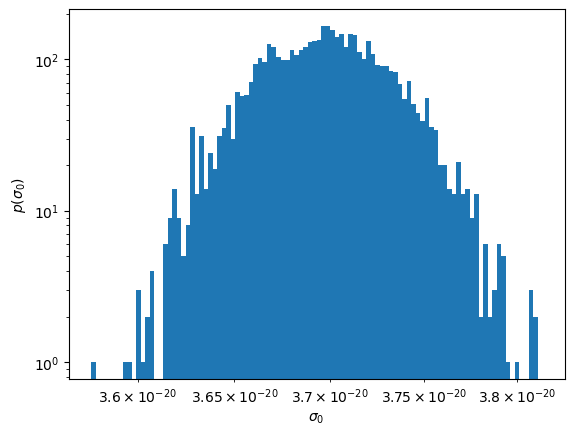

In [250]:
samples = sampler.get_chain(flat=True)
plot_loghist(samples[:, 0], 100)
plt.xlabel(r"$\sigma_0$")
plt.ylabel(r"$p(\sigma_0)$")



In [251]:
np.median(samples)

3.698200939984775e-20

In [252]:
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(sampler.acceptance_fraction)
    )
)

Mean acceptance fraction: 0.822


In [253]:
print(
    "Mean autocorrelation time: {0:.3f} steps".format(
        np.mean(sampler.get_autocorr_time())
    )
)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.1271992]